In [1]:
import numpy as np
from scene import Scene
from matplotlib import pyplot as plt
%matplotlib inline

## Load data

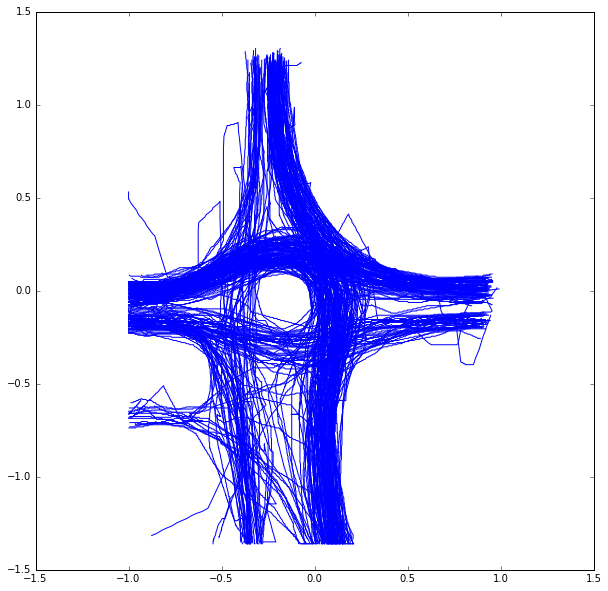

In [2]:
from process_data import get_BB_ts_list, BB_ts_to_curve, BB_to_position_and_velocity
BB_ts_list, V_scale = get_BB_ts_list('../annotations/deathCircle/video3/', label='Biker')
curve_list = map( BB_ts_to_curve, BB_ts_list )

fig = plt.figure( figsize = (10,10))
for BB_ts in BB_ts_list:
    plt.plot(BB_ts[0] , BB_ts[1], 'b-')
plt.axis('equal')
plt.show()

## Generate train-test split

In [3]:
from sklearn.cross_validation import KFold, train_test_split
n = len(BB_ts_list)
n_folds = 5
#kf = KFold(n, n_folds=n_folds, random_state = 42)
#for train, test in kf:
#    print "train = " + str(train)
#    print "test  = " + str(test)

In [4]:
train, test = train_test_split( BB_ts_list, random_state = 42)

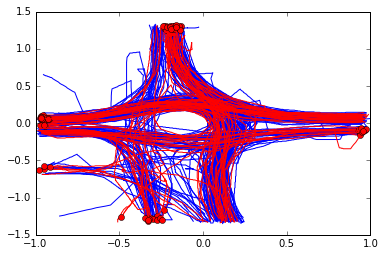

In [5]:
for BB_ts in train:
    x,y = BB_ts_to_curve(BB_ts)
    plt.plot( x, y, 'b-')
    
for BB_ts in test:
    x,y = BB_ts_to_curve( BB_ts )
    plt.plot(x, y, 'r-')
    plt.plot(x[0], y[0], 'ro')

## Train and see a prediction

Top speed = 0.190671
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
[ 0.18181818  0.17316017  0.17748918  0.04761905  0.04761905  0.08658009
  0.08225108  0.03463203  0.06926407  0.0995671 ]


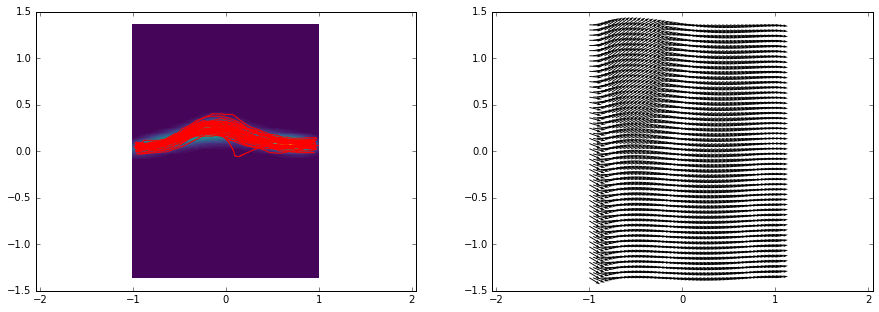

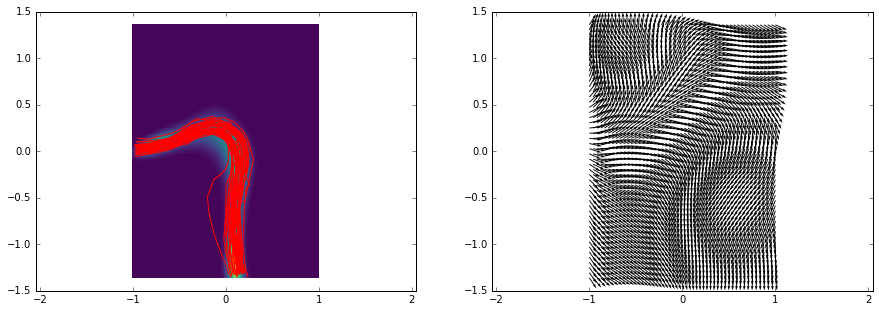

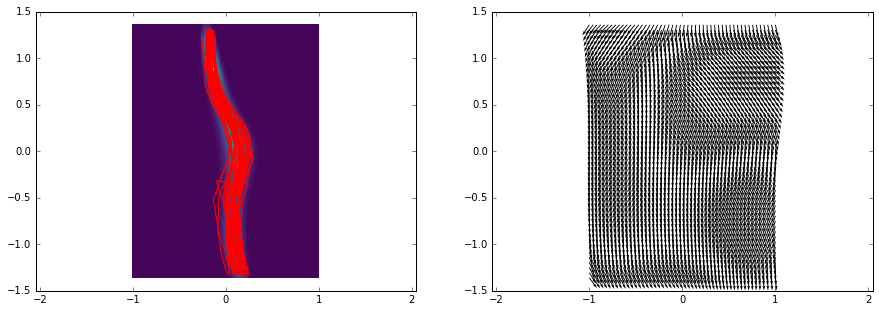

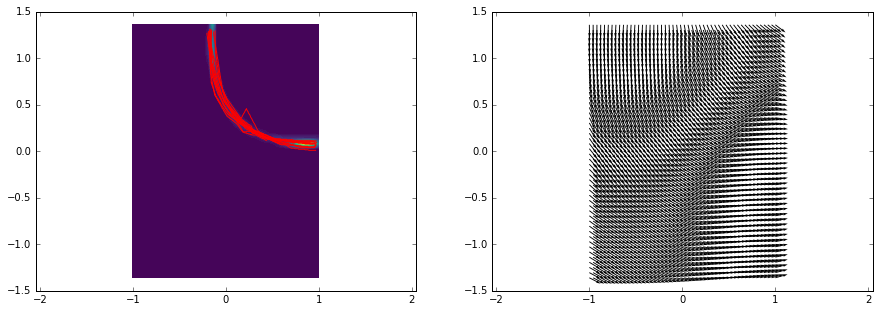

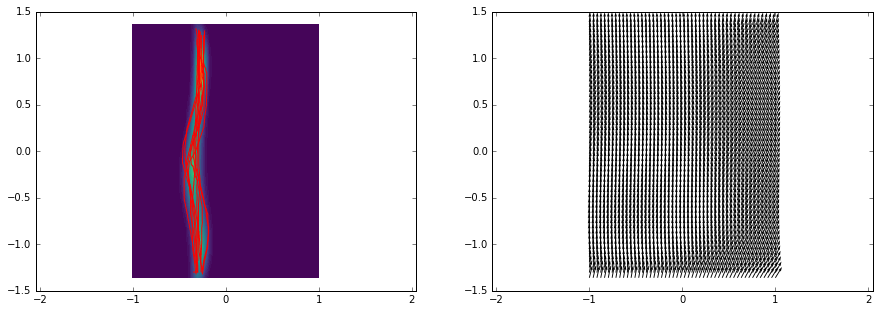

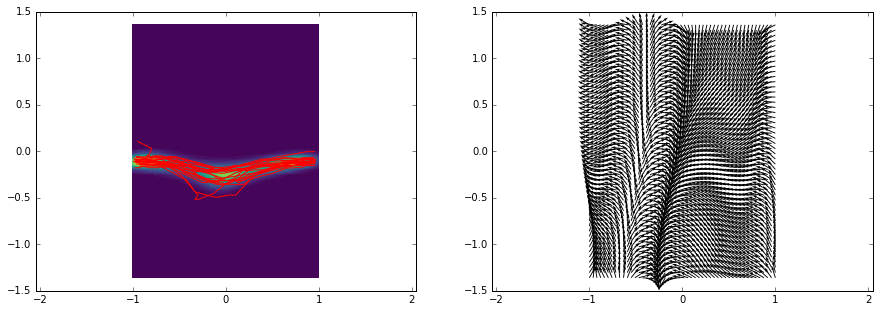

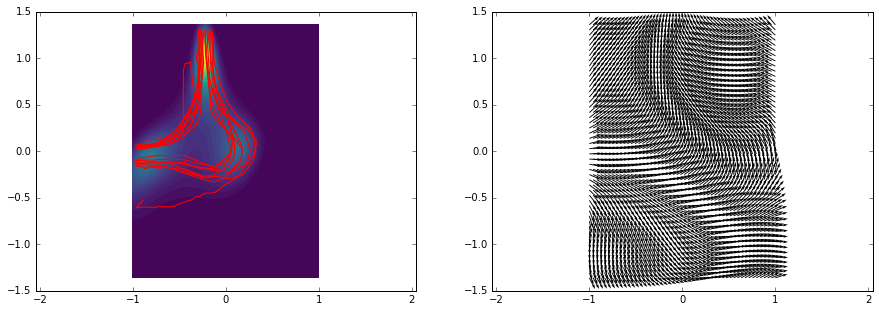

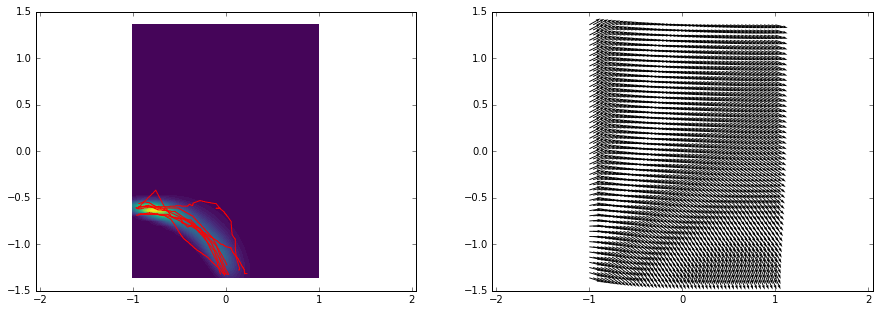

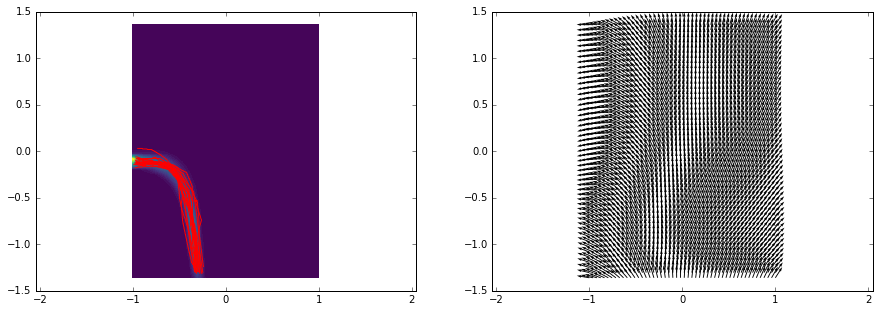

In [6]:
curve_list = map( BB_ts_to_curve, train )
scene = Scene( curve_list, V_scale, k_max_theta=15, k_max_vf=15 )

for k in range(scene.num_nl_classes):
    from visualization_routines import visualize_cluster
    visualize_cluster( scene, k)

integral of Us = nan
integral of Linear = 0.013621
363


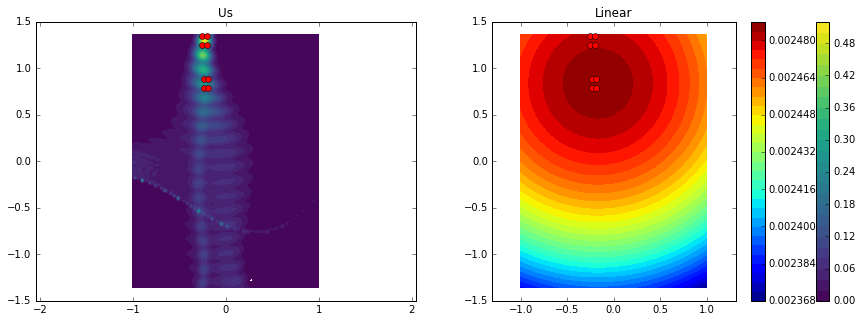

In [13]:
t0 = 2
subj = 0
BB_0 = test[subj][:,t0-2]
BB_1 = test[subj][:,t0+2]
mu, eta = BB_to_position_and_velocity(  BB_0, BB_1, delta_t = 4 )
scene.set_mu( mu )
scene.set_eta( eta )

x_span = np.linspace( -V_scale[0], V_scale[0], 100 )
y_span = np.linspace( -V_scale[1], V_scale[1], 100 )
dx, dy = x_span[1] - x_span[0], y_span[1] - y_span[0]
X_grid, Y_grid = np.meshgrid( x_span, y_span)

T=80
rho = scene.predict_pdf( X_grid, Y_grid, T)
fig, ax_arr = plt.subplots( 1,2, figsize = (15,5))
cs = ax_arr[0].contourf( X_grid, Y_grid, rho, 30, cmap = 'viridis')
#plot bounding boxes
for BB in [ 0.5*(BB_0+BB_1), test[subj][:,T]]:
    ax_arr[0].plot( [BB[0], BB[0], BB[2], BB[2] ], [BB[1],BB[3],BB[1],BB[3]], 'ro')
axis_lengths = ax_arr[0].axis('equal')
ax_arr[0].set_title('Us')
plt.colorbar(cs)

print "integral of Us = %f" % (rho.sum()*dx*dy)

rho_linear = scene.predict_pdf_linear( X_grid, Y_grid, T)
cs = ax_arr[1].contourf( X_grid, Y_grid, rho_linear, 30, cmap = 'jet')
plt.colorbar(cs)
#plot bounding boxes
for BB in [ 0.5*(BB_0+BB_1), test[subj][:,T]]:
    ax_arr[1].plot( [BB[0], BB[0], BB[2], BB[2] ], [BB[1],BB[3],BB[1],BB[3]], 'ro')
axis_lengths = ax_arr[1].axis('equal')
ax_arr[1].set_title('Linear')

print "integral of Linear = %f" % (rho_linear.sum()*dx*dy)
print map( np.isnan, rho.flatten() ).index(True)
#print [ (i,j) for  (i,j) in izip( xrange(rho.shape[0]), xrange(rho.shape[1])) if np.isnan(rho[i,j]) ]

## Measure Accuracy at a single T
To measure precision we consider a bounding box, $BB(T)$, at time $T > 0$ and test if
$$
    \int_{BB(T)} \rho_{\text{pred}} (T,x) dx > p_{\min}
$$
where $p_{\min}$ is something like $1\%$.  Perfect precision occurs when this test passes in all cases.

In [ ]:
accuracy = 0
accuracy_linear = 0
p_min = 1e-3
for subj in range( len(test)):
    # Generate a grid over the bounding box at time T, compute prediction on the bounding box.
    BB_T = test[subj][:,T]
    x_span = np.linspace( BB_T[0], BB_T[2], 10)
    y_span = np.linspace( BB_T[1], BB_T[3], 10)
    X_grid, Y_grid = np.meshgrid( x_span, y_span)
    dx, dy = x_span[1] - x_span[0], y_span[1] - y_span[0]

    # initialize the scene
    t0 = 2
    BB_0 = test[subj][:,t0-2]
    BB_1 = test[subj][:,t0+2]
    mu, eta = BB_to_position_and_velocity(  BB_0, BB_1, delta_t = 4 )
    scene.set_mu( mu )
    scene.set_eta( eta )
    
    # Compute pdf on mesh
    rho = scene.predict_pdf( X_grid, Y_grid, T)
    rho_linear = scene.predict_pdf_linear( X_grid, Y_grid, T)
    # Compute integral
    Us = rho.sum()*dx*dy
    Linear = rho_linear.sum()*dx*dy
    print "Us     = %f" % Us
    print "Linear = %f" % Linear
    accuracy += 1 if Us > p_min else 0
    accuracy_linear += 1 if Linear > p_min else 0
    
print "our accuracy    = %d out of %d" % (accuracy, len(test))
print "linear accuracy = %d out of %d" % (accuracy_linear, len(test))

Us     = 0.001954
Linear = 0.000027
Us     = 0.004128
Linear = 0.000044
Us     = 0.013054
Linear = 0.000071
Us     = 0.002125
Linear = 0.000029
Us     = 0.016222
Linear = 0.000065
Us     = 0.002646
Linear = 0.000047
Us     = 0.005177
Linear = 0.000054
Us     = 0.011213
Linear = 0.000090
Us     = 0.010670
Linear = 0.000047
Us     = 0.002639
Linear = 0.000053
Us     = 0.006358
Linear = 0.000054
Us     = 0.003109
Linear = 0.000030
Us     = 0.008476
Linear = 0.000045
Us     = 0.006597
Linear = 0.000033
Us     = 0.001289
Linear = 0.000027
Us     = 0.001692
Linear = 0.000046
Us     = 0.013800
Linear = 0.000079
Us     = 0.000822
Linear = 0.000021
Us     = 0.001373
Linear = 0.000029
Us     = 0.009331
Linear = 0.000042
Us     = 0.002711
Linear = 0.000043
Us     = 0.002208
Linear = 0.000033
Us     = 0.001305
Linear = 0.000024
Us     = 0.001331
Linear = 0.000023
Us     = 0.007005
Linear = 0.000107
Us     = 0.002095
Linear = 0.000027
Us     = 0.003544
Linear = 0.000031
Us     = 0.010527
Linear = 0

## Computing Precision at a single time
We compute how often our accuracy test gives a positive result.  That is, we want to compute the number of times
$$
    \int_BB \rho_{\text{pred}}(T,x) dx > p_\min
$$
over bounding boxes that tile the space.  As a rough approximation, we can instead compute how often
$$
    \text{Area}(BB) \cdot \rho_{\text{pred}}(T, BB_{text{center}}) > p_\min
$$


In [17]:
precision_us = 0.0
precision_lin = 0.0
for subj in range( len(test)):
    BB_T = test[subj][:,T]
    dx = BB_T[2] - BB_T[0]
    dy = BB_T[3] - BB_T[1]
    Area = dx*dy
    nx = int( V_scale[0] / dx)
    ny = int( V_scale[1] / dy)
    x_span = np.linspace( -V_scale[0], V_scale[0], 2*nx)
    y_span = np.linspace( -V_scale[1], V_scale[1], 2*ny)
    X_grid, Y_grid = np.meshgrid( x_span, y_span)

    # initialize the scene
    t0 = 2
    BB_0 = test[subj][:,t0-2]
    BB_1 = test[subj][:,t0+2]
    mu, eta = BB_to_position_and_velocity(  BB_0, BB_1, delta_t = 4 )
    scene.set_mu( mu )
    scene.set_eta( eta )
    
    # Compute pdf on mesh
    rho = scene.predict_pdf( X_grid, Y_grid, T)
    rho_linear = scene.predict_pdf_linear( X_grid, Y_grid, T)
    # Compute integral
    precision_us += sum( 1 for p in list(rho.flatten()*dx*dy) if p > p_min)
    precision_lin += sum( 1 for p in list(rho_linear.flatten()*dx*dy) if p > p_min)
    print "Computed subjected %d" % subj

#precision_us = precision_us**-1
#precision_lin = precision_lin**-1
print "our precision      = %f" % precision_us
print "Linear's precision = %f" % precision_lin

Computed subjected 0
Computed subjected 1
Computed subjected 2
Computed subjected 3
Computed subjected 4
Computed subjected 5
Computed subjected 6
Computed subjected 7
Computed subjected 8
Computed subjected 9
Computed subjected 10
Computed subjected 11
Computed subjected 12
Computed subjected 13
Computed subjected 14
Computed subjected 15
Computed subjected 16
Computed subjected 17
Computed subjected 18
Computed subjected 19
Computed subjected 20
Computed subjected 21
Computed subjected 22
Computed subjected 23
Computed subjected 24
Computed subjected 25
Computed subjected 26
Computed subjected 27
Computed subjected 28
Computed subjected 29
Computed subjected 30
Computed subjected 31
Computed subjected 32
Computed subjected 33
Computed subjected 34
Computed subjected 35
Computed subjected 36
Computed subjected 37
Computed subjected 38
Computed subjected 39
Computed subjected 40
Computed subjected 41
Computed subjected 42
Computed subjected 43
Computed subjected 44
Computed subjected 4

ZeroDivisionError: 0.0 cannot be raised to a negative power

In [24]:
print precision_us

3592.0


In [23]:
print precision_lin

0.0
